In [1]:
import os 
import sys
import random
import numpy as np
import cv2
from imgaug import augmenters as iaa
import tensorflow as tf
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

ROOT_DIR = os.getcwd()
DATA_DIR = ROOT_DIR+'/train'
ROOT_MODEL = ROOT_DIR+'/models'

sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

## ---------------------- function ----------------------

def masks_as_image(in_mask_list, all_masks=None):
    if all_masks is None:
        all_masks = np.zeros((768, 768), dtype = np.int16)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

def rle_decode(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

/Users/yannis/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/yannis/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### ---------------------- Config ----------------------

In [2]:
class DetectorConfig(Config):
    NAME = 'Airbus'
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 3
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
   
    IMAGE_MIN_DIM = 500
    IMAGE_MAX_DIM = 500
    
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 10

#### ---------------------- Dataset ----------------------

In [31]:
class DetectorDataset(utils.Dataset):
    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('airbus', 1, 'ship')
   
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations.item()[fp]
            self.add_image('airbus', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        image = cv2.imread("train/"+fp)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
        for i, a in enumerate(annotations):
            imgmax = masks_as_image([a])
            mask[:, :, i] = imgmax[:,:,0]

        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

#### ---------------------- Visualize ----------------------

In [32]:
ORIG_SIZE = 768
config = DetectorConfig()

image_fps = np.load("images_ids.npy")
image_annotations = np.load("images_annotations.npy")

image_fps_train, image_fps_val = train_test_split(image_fps, test_size=0.1)

In [33]:
dataset = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset.prepare()

In [34]:
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 26163
Class Count: 2
  0. BG                                                
  1. ship                                              


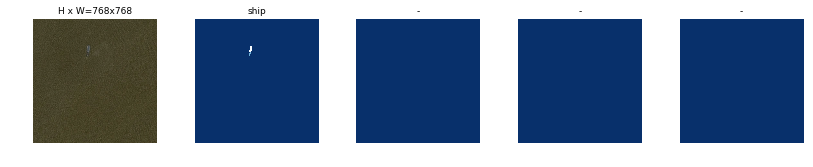

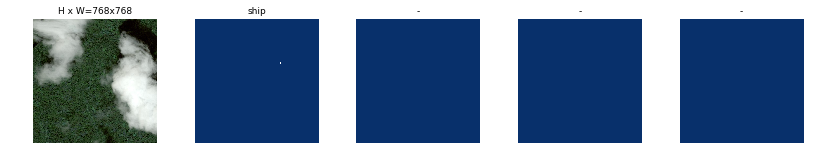

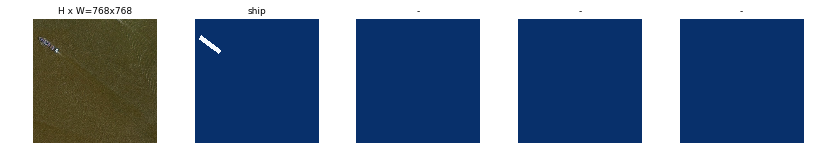

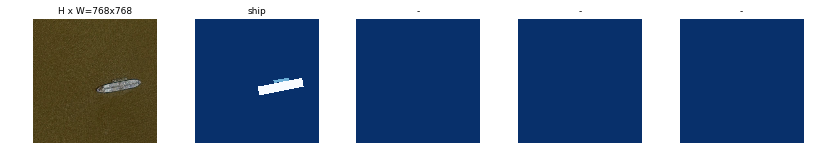

In [35]:
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

molded_image             shape: (500, 500, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (500, 500, 3)         min:    0.00000  max:    1.00000  bool


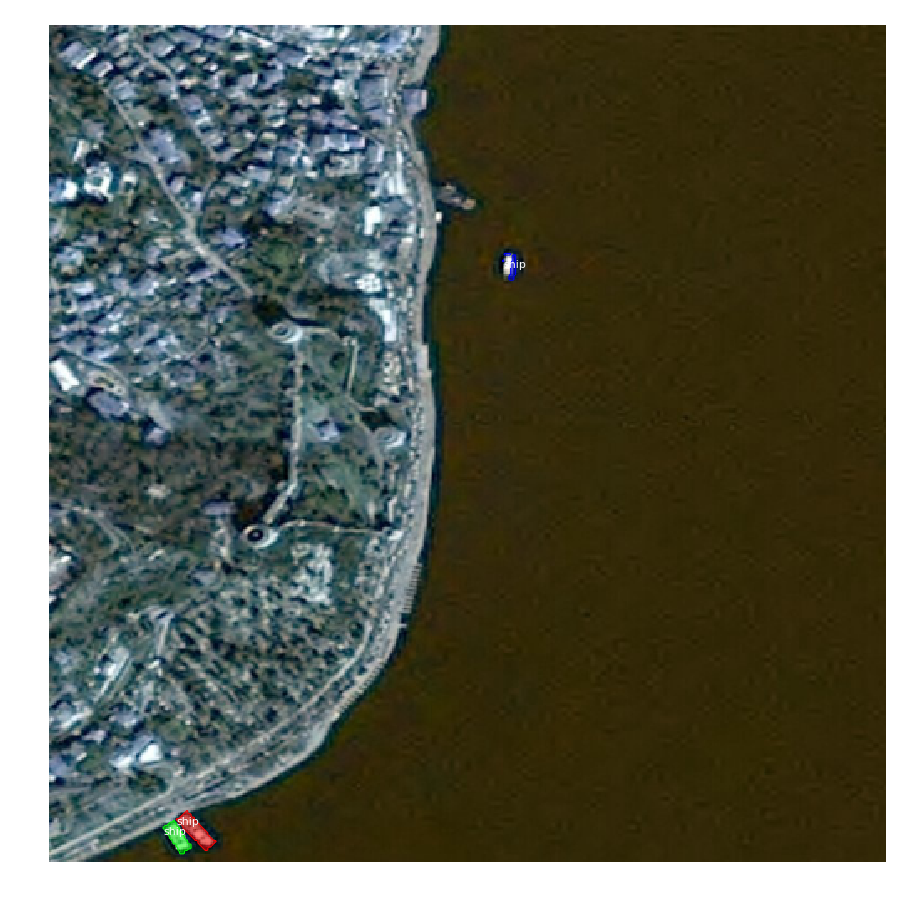

In [42]:
image_id = 40

# Load and display
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, config, image_id, use_mini_mask=False)
log("molded_image", image)
log("mask", mask)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names,
                            show_bbox=False)